# Weighted Least Squares (WLS) state estimation for PV parameters

In [28]:
import os
import json
import math
from oedisi.types.data_types import MeasurementArray, AdmittanceMatrix, Topology
import pyarrow.feather as feather
import numpy as np
import datetime as dt
import random
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import glob

ROOT = os.getcwd()
OUTPUTS = f"{ROOT}/outputs"
BUILDS = f"{ROOT}/builds"
SCENARIOS = f"{ROOT}/scenarios"

## Run OEDISI
Each scenario is defined in the following folder structure:
- algorithm / model / pv-level / es-level

The following shows which scenarios have been generated using one of the algorithm generation scripts

In [29]:
dir = []
def list_files_scandir(path="."):
    with os.scandir(path) as entries:
        for entry in entries:
            if entry.is_file():
                if "system.json" in entry.path:
                    path, _ = entry.path.split("system.json", 1)
                    dir.append(path)
            elif entry.is_dir():
                list_files_scandir(entry.path)


# Specify the directory path you want to start from
directory_path = f"{SCENARIOS}/ekf"
list_files_scandir(directory_path)
for i, d in enumerate(dir):
    print(i, d)

0 /home/tylor/dev/oedisi_dopf/scenarios/ekf/ieee123_pmu/
1 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P6U/extreme/
2 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P6U/low/
3 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P6U/high/
4 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P6U/medium/
5 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P9U/extreme/
6 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P9U/low/
7 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P9U/high/
8 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P9U/medium/
9 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P3U/extreme/
10 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P3U/low/
11 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P3U/high/
12 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P3U/medium/
13 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P1U/extreme/
14 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P1U/low/
15 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P1U/high/
16 /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P1U/

In [30]:
index = 14
path = dir[index]
_, scenario = path.split(SCENARIOS, 1)
build = f"{BUILDS}{scenario}"
output = f"{OUTPUTS}{scenario}"
os.system(
    f"oedisi build --system {path}system.json --component-dict {path}components.json --target-directory {build}"
)

Loading the components defined in /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P1U/low/components.json
Loading system json /home/tylor/dev/oedisi_dopf/scenarios/ekf/SFO/P1U/low/system.json
Building system in /home/tylor/dev/oedisi_dopf/builds/ekf/SFO/P1U/low/


0

In [31]:
os.system("pkill -9 helics_broker")
os.system(f"oedisi run --runner {build}system_runner.json")

[warn] helics-cli's web interface is not installed. You may want to run `pip install "helics[cli]"`.
[warn] helics-cli's observer functionality is not installed. You may want to run `pip install "helics[cli]"`.
[info] Running federation: ekf_SFO/P1U
[info] Running federate feeder as a background process
[info] Running federate ekf as a background process
[info] Running federate recorder_voltage_real as a background process
[info] Running federate recorder_voltage_imag as a background process
[info] Running federate recorder_power_real as a background process
[info] Running federate sensor_power_real as a background process
[info] Running federate recorder_power_imag as a background process
[info] Running federate sensor_power_imag as a background process
[info] Running federate recorder_voltage_mag as a background process
[info] Running federate sensor_voltage_mag as a background process
[info] Running federate recorder_voltage_angle as a background process
[info] Running federate brok

0

## Load Data

In [32]:
topology = Topology.parse_file(f"{output}/topology.json")
base_voltage_df = pd.DataFrame(
    {
        "id": topology.base_voltage_magnitudes.ids,
        "value": topology.base_voltage_magnitudes.values,
    }
)
base_voltage_df.set_index("id", inplace=True)
base_voltages = base_voltage_df["value"]

In [33]:
# read data
v_real = feather.read_feather(f"{output}/voltage_real.feather")
v_imag = feather.read_feather(f"{output}/voltage_imag.feather")

# converter to complex
true_voltages = v_real.drop("time", axis=1).abs() + 1j * v_imag.drop("time", axis=1)
true_voltages["time"] = pd.to_datetime(v_real["time"], format="%Y-%m-%d %H:%M:%S")
true_voltages.set_index("time", inplace=True)

In [34]:
# read data
v_mag = feather.read_feather(f"{output}/voltage_mag.feather")
v_angle = feather.read_feather(f"{output}/voltage_angle.feather")

# filter missing nodes
common_columns = set(v_mag.columns).intersection(v_angle.columns)
v_mag = v_mag.filter(common_columns)
v_angle = v_angle.filter(common_columns)

# convert to complex
v_rad = np.radians(v_angle.drop("time", axis=1).to_numpy())
est_voltages = v_mag.drop("time", axis=1) * np.exp(1j * v_rad)
est_voltages["time"] = pd.to_datetime(v_mag["time"], format="%Y-%m-%d %H:%M:%S")
est_voltages.set_index("time", inplace=True)

## Process Data

MSRE:  0.0013908755592516274


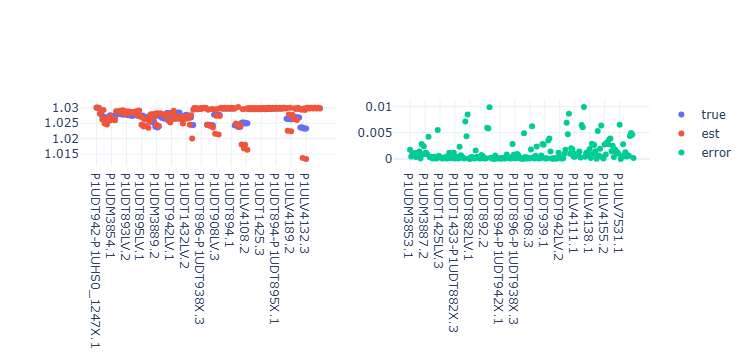

In [42]:
ts = dt.datetime(2017, 5, 1, 12)
true = true_voltages.loc[ts].abs() / base_voltages
est = est_voltages.loc[ts].abs() / base_voltages

error = (true - est).abs()
print("MSRE: ", sum(error)/len(error))

fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Scatter(name="true", x=true.index, y=true.values, mode="markers"), row=1, col=1
)
fig.add_trace(
    go.Scatter(name="est", x=est.index, y=est.values, mode="markers"), row=1, col=1
)
fig.add_trace(
    go.Scatter(name="error", x=error.index, y=error.values, mode="markers"),
    row=1,
    col=2,
)
fig.update_layout(template="plotly_white")
fig.show()

time
2017-05-01 04:01:12    1.024624
2017-05-01 06:00:00    1.024310
2017-05-01 08:00:00    1.023730
2017-05-01 10:00:00    1.023796
2017-05-01 12:00:00    1.023836
2017-05-01 14:00:00    1.024401
2017-05-01 16:00:00    1.024529
2017-05-01 18:00:00    1.024490
Name: P1ULV7531.3, dtype: float64
time
2017-05-01 06:00:00    1.023657
2017-05-01 06:00:00    1.024222
2017-05-01 10:00:00    1.024176
2017-05-01 12:00:00    1.024312
2017-05-01 14:00:00    1.024381
2017-05-01 16:00:00    1.024486
Name: P1ULV7531.3, dtype: float64


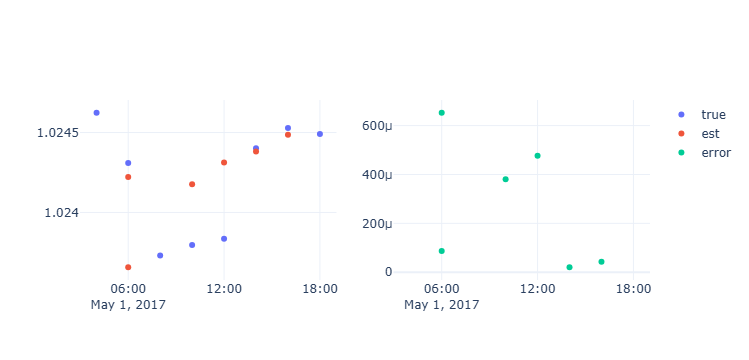

In [39]:
true = true_voltages.abs() / base_voltages
est = est_voltages.abs() / base_voltages

node = random.choice(true.columns)
true = true.loc[:,node]
est = est.loc[:,node]

error = (true - est).abs()

fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Scatter(name="true", x=true.index, y=true.values, mode="markers"), row=1, col=1
)
fig.add_trace(
    go.Scatter(name="est", x=est.index, y=est.values, mode="markers"), row=1, col=1
)
fig.add_trace(
    go.Scatter(name="error", x=error.index, y=error.values, mode="markers"),
    row=1,
    col=2,
)
fig.update_layout(template="plotly_white")
fig.show()